In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image, ImageOps

import random
import os
import json

matplotlib.rcParams['figure.figsize'] = (11.75, 8.5)

## Исходные данные

In [2]:
data = np.load('seistrain4.npz')['arr_0']
print(type(data))
print(data.dtype)
print(np.shape(data))

<class 'numpy.ndarray'>
float64
(100, 3174, 1537)


## Размеченные данные

In [3]:
labels = np.load('faulttrain4.npz')['arr_0']
print(type(labels))
print(labels.dtype)
print(np.shape(labels))

<class 'numpy.ndarray'>
bool
(100, 3174, 1537)


((225, 225), 3433)

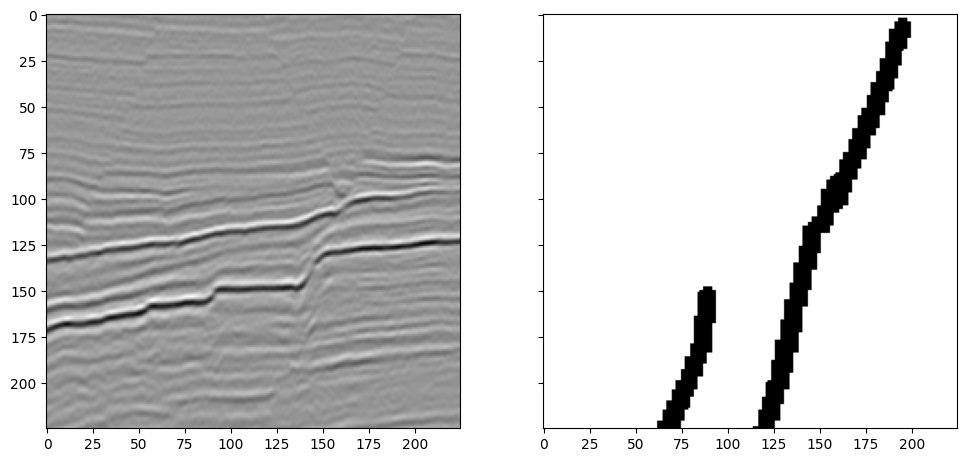

In [4]:
def plot_data_and_labels(data, labels):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    ax1.imshow(data.T, cmap='gray_r')
    ax2.imshow(labels.T, cmap='gray_r')

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.imshow(data[20,775:1000,800:1025].T, cmap='gray_r')
ax2.imshow(labels[20,775:1000,800:1025].T, cmap='gray_r')
np.shape(labels[20,775:1000,800:1025]), np.sum(labels[20,775:1000,800:1025])

## Порог для отбора окна - сумма превышающая 2000

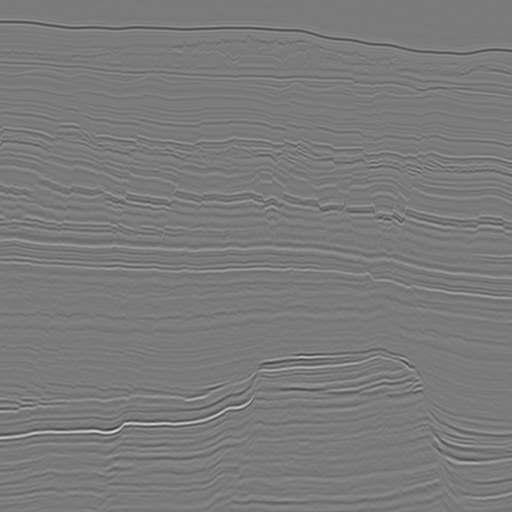

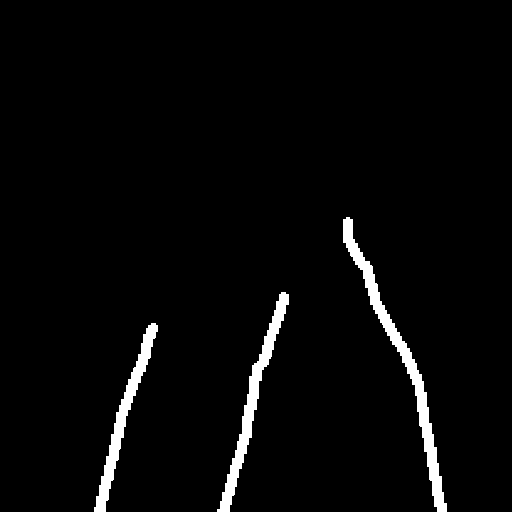

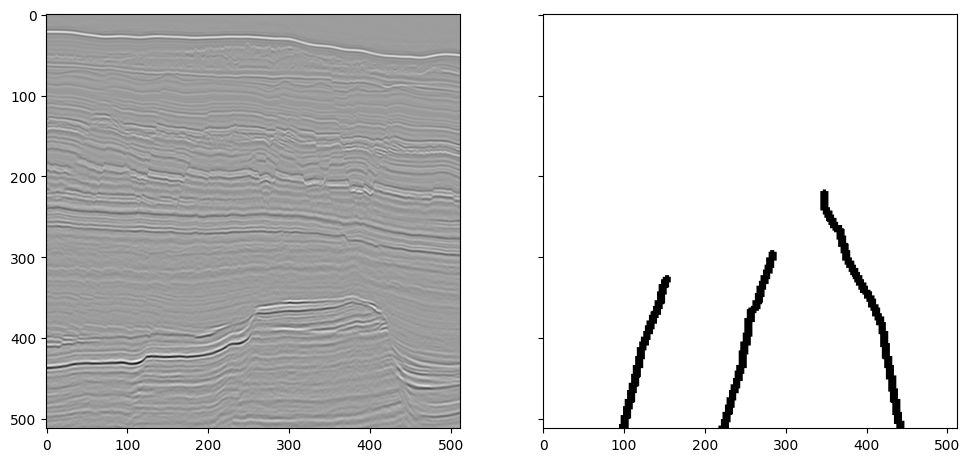

In [5]:
xlines, inlines, timelines = np.shape(labels)

window_threshold = 2000
window_size = 512

min_data_value = np.min(data)
max_data_value = np.max(data)
normalized_data = (data - min_data_value) / (max_data_value - min_data_value) * 255

def get_random_window(data, labels, window_size, window_thresh, xlines_window, inlines_window, timelines_window):
    while True:
        random_xline = random.randint(xlines_window[0], xlines_window[1])
        random_inline = random.randint(inlines_window[0], inlines_window[1])
        random_timeline = random.randint(timelines_window[0], timelines_window[1])
        random_data_window = data[random_xline, random_inline:random_inline+window_size, random_timeline:random_timeline+window_size]
        random_label_window = labels[random_xline, random_inline:random_inline+window_size, random_timeline:random_timeline+window_size]
        if np.sum(random_label_window) > window_thresh:
            return random_data_window, random_label_window

data_window, label_window = get_random_window(normalized_data, labels, window_size, window_threshold, xlines_window=(0, 80), inlines_window=(0, inlines-window_size), timelines_window=(0, timelines-window_size))
data_img = ImageOps.grayscale(Image.fromarray(data_window.T))
label_img = ImageOps.grayscale(Image.fromarray(label_window.T))
plot_data_and_labels(data_window, label_window)
display(data_img)
display(label_img)

In [6]:
for stage in ("train", "eval"):
    if stage == "train":
        num_images = 700
        xlines_window = (11, 99)
    else:
        num_images = 100
        xlines_window = (0, 10)
    fault_path = os.path.join('data', stage, 'fault')
    seis_path = os.path.join('data', stage, 'seis')

    metadata = []
    for i in range(num_images):
        data_window, label_window = get_random_window(normalized_data, labels, window_size, window_threshold, xlines_window=xlines_window, inlines_window=(0, inlines-window_size), timelines_window=(0, timelines-window_size))
        data_img = ImageOps.grayscale(Image.fromarray(data_window.T))
        label_img = ImageOps.grayscale(Image.fromarray(label_window.T))
        metadata.append({
            "data": f"{i}.jpeg",
            "label": f"{i}.jpeg",
        })
        data_img.save(os.path.join(seis_path, f"{i}.jpeg"))
        label_img.save(os.path.join(fault_path, f"{i}.jpeg"))
    with open(os.path.join("data", stage, "metadata.json"), "w") as file:
        json.dump(metadata, file)